# TRAFFIC SIGN RECOGNITION PROJECT

#### PROBLEM STATEMENT

Traffic signs are the "language" of the roads. For autonomous vehicles or driver-assist systems to function safely, they must be able to recognize and interpret these signs in real-time. In this notebook, I'll be building a Deep Learning model to classify 43 different types of traffic signs using the German Traffic Sign Recognition Benchmark (GTSRB) dataset.

The goal is simple but challenging: build a robust classifier that can handle variations in lighting, weather conditions, and motion blur. Since we have 43 distinct categories, this is a multi-class classification problem where accuracy is critical for safety.

In [16]:
kitu = pd.read_csv(test_csv_path)
print(kitu.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


### LOAD DATASET AND IMPORT LIBRARIES

In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## EDA


In [2]:
# Install required nbformat for proper notebook rendering
%pip install "nbformat>=4.2.0"

# Visualizing Class Distribution
import plotly.express as px

# Path to your training data (use raw string to avoid unicode escape issues)
train_path = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset\Train'
data_list = []
classes = []

for i in range(43):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)
    data_list.append(len(images))
    classes.append(str(i))

# Creating a beautiful bar chart for distribution
fig = px.bar(x=classes, y=data_list, labels={'x': 'Class ID', 'y': 'Number of Images'},
             title='Distribution of Images per Class', color=data_list)
fig.show()

Note: you may need to restart the kernel to use updated packages.


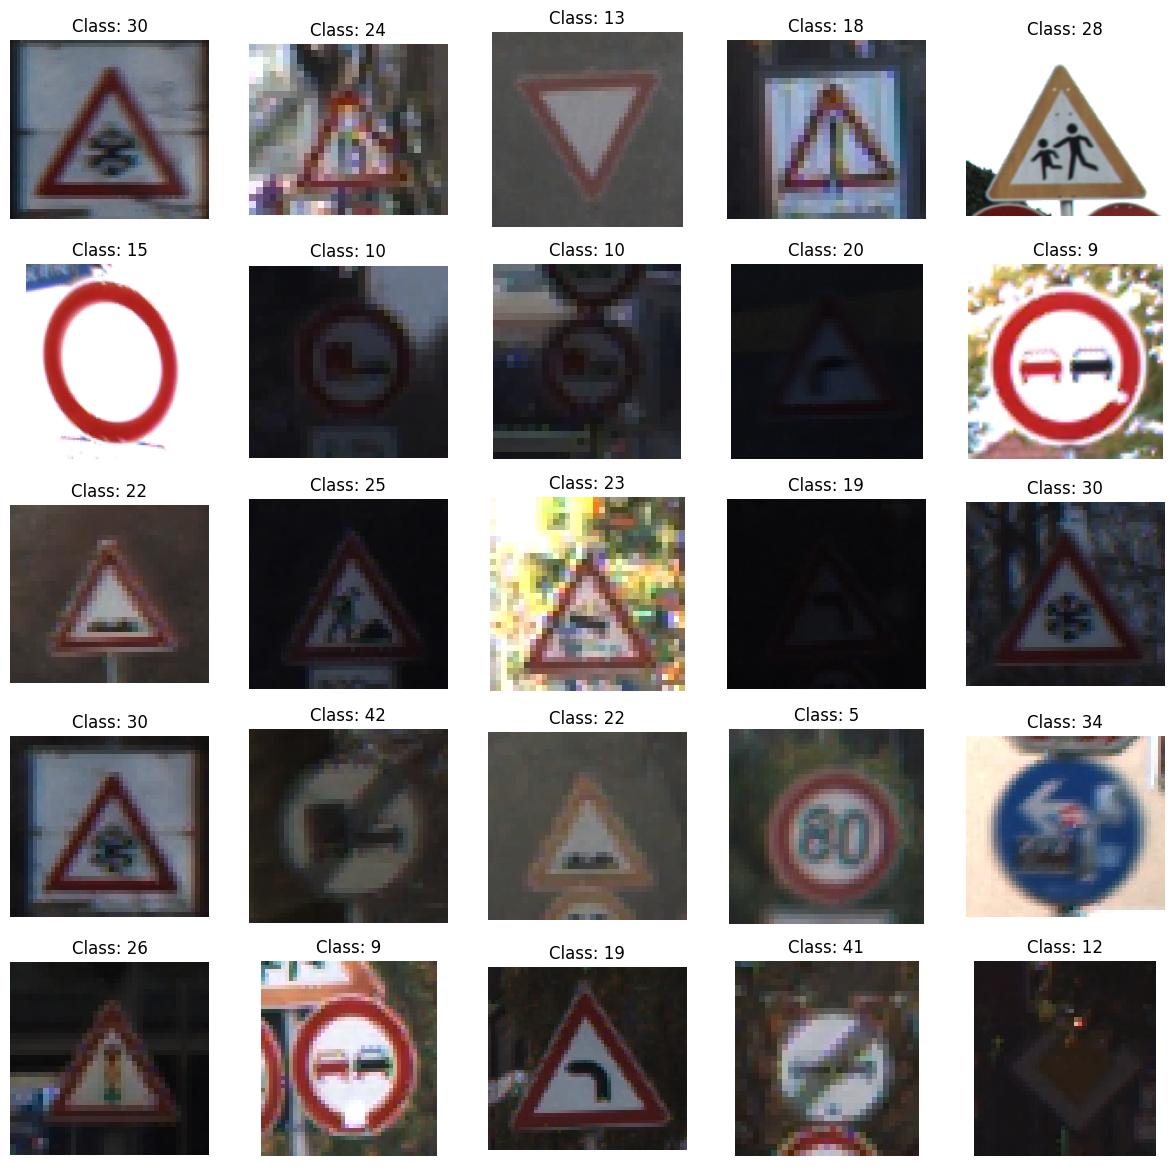

In [3]:
# Visualizing Sample Images
import random

# Visualizing random samples from the dataset
plt.figure(figsize=(12, 12))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.tight_layout()
    
    # Pick a random class and a random image from it
    rand_class = random.randint(0, 42)
    path = os.path.join(train_path, str(rand_class))
    rand_img = random.choice(os.listdir(path))
    
    img = Image.open(os.path.join(path, rand_img))
    plt.imshow(img)
    plt.title(f'Class: {rand_class}')
    plt.axis('off')

plt.show()

## DATA PRE-PROCESSING AND AUGMENTATION

In this stage, we prepare the images for the CNN. Since raw images vary in size and lighting, we standardize them and then apply Data Augmentation. Augmentation is vital here because it helps the model generalize better by exposing it to different variations (rotations, shifts, zooms) of the same sign.

Note: We intentionally skip horizontal_flip because traffic signs are directional. A 'Turn Left' sign flipped becomes 'Turn Right', which would lead to incorrect labeling.

In [4]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Loading training images
for i in range(classes):
    # prefer absolute train_path if available, otherwise build path from cur_path
    if 'train_path' in globals():
        path = os.path.join(train_path, str(i))
    else:
        path = os.path.join(cur_path, 'dataset', 'Train', str(i))

    # skip missing directories and warn
    if not os.path.isdir(path):
        print(f"Warning: Directory not found, skipping: {path}")
        continue

    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30,30)) # Standardizing size
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image '{a}' in '{path}': {e}")

# Converting lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Total images loaded: {data.shape[0]}")
print(f"Shape of data: {data.shape}") 

Total images loaded: 39209
Shape of data: (39209, 30, 30, 3)


In [5]:
# Standardizing the Image Data
X_data = np.array(data)

# Normalization
X_data = X_data.astype('float32') / 255.0  
y_labels = np.array(labels)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_labels, test_size=0.2, random_state=42)

# One-Hot Encoding for the labels
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Defining the Augmentation Strategy
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest"
)

print(f"Final Training shape: {X_train.shape}")
print(f"Final Validation shape: {X_val.shape}")

Final Training shape: (31367, 30, 30, 3)
Final Validation shape: (7842, 30, 30, 3)


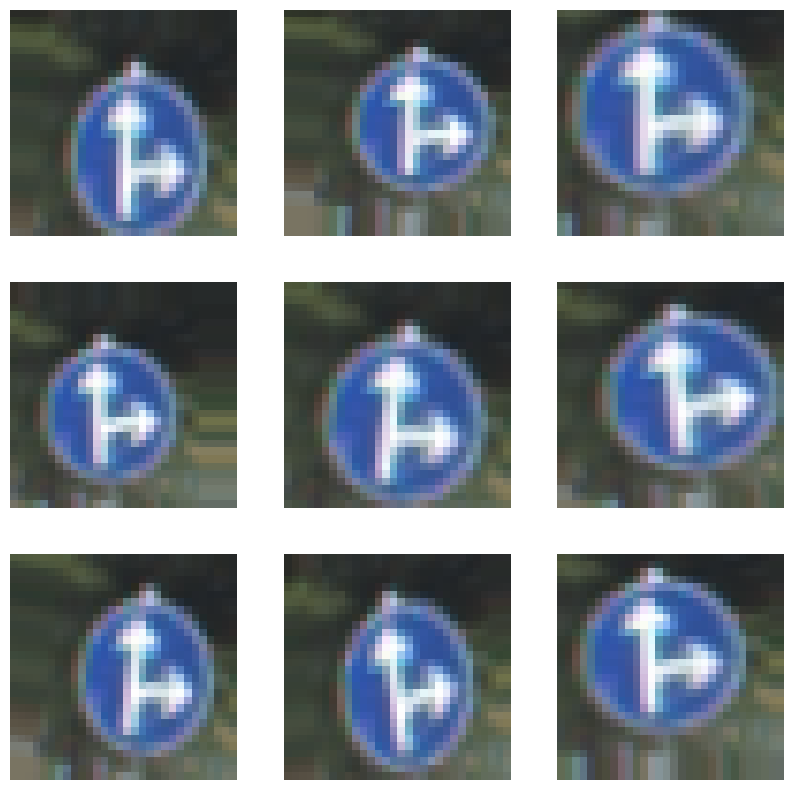

In [6]:
# Visualization of Augmented Images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Generating a batch of augmented images
    batch = aug.flow(np.expand_dims(X_train[0], 0), batch_size=1)
    img = batch[0][0]
    plt.imshow(img)
    plt.axis('off')
plt.show()

## MODELLING

In [7]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Flattening and Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax')) # 43 classes for 43 signs

# Compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\judew\OneDrive\Desktop\Zindua\ml_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

#### MODEL TRAINING

In [8]:
epochs = 6
batch_size = 32

# Training the model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.3702 - loss: 2.1687 - val_accuracy: 0.8231 - val_loss: 0.5807
Epoch 2/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.7485 - loss: 0.7887 - val_accuracy: 0.9652 - val_loss: 0.1350
Epoch 3/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8541 - loss: 0.4683 - val_accuracy: 0.9759 - val_loss: 0.0730
Epoch 4/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8984 - loss: 0.3306 - val_accuracy: 0.9897 - val_loss: 0.0411
Epoch 5/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9181 - loss: 0.2633 - val_accuracy: 0.9843 - val_loss: 0.0543
Epoch 6/6
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9328 - loss: 0.2242 - val_accuracy: 0.9894 - val_loss: 0.0355


### MODEL EVALUATION

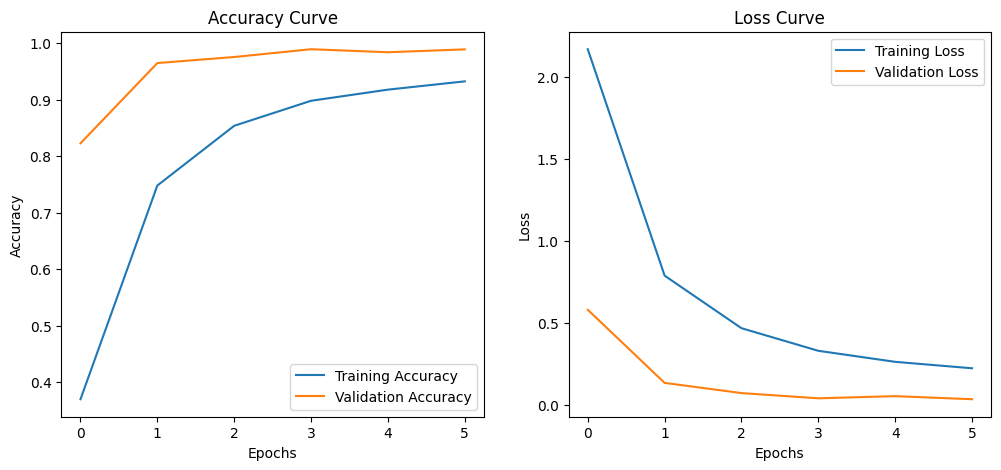

In [9]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### TESTING ON UNSEEN DATA

In [10]:
# Loading the test dataset
test_csv_path = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset\Test.csv'
test_df = pd.read_csv(test_csv_path)
y_test = test_df["ClassId"].values
imgs = test_df["Path"].values

data = []

# Base folder for test images
base_dir = r'C:\Users\judew\OneDrive\Desktop\Zindua\Traffic_sign_recogntion project\dataset'

# Processing test images exactly like we did for training
for img in imgs:
    try:
        img_path = img
        if not os.path.isabs(img_path):
            img_path = os.path.join(base_dir, img_path.replace('/', os.sep).lstrip(os.sep))
        image = Image.open(img_path)
        image = image.resize((30,30))
        data.append(np.array(image))
    except Exception as e:
        print(f"Error loading test image '{img}': {e}")

X_test = np.array(data)

# Normalization
X_test = X_test.astype('float32') / 255.0

# Making predictions
predictions = model.predict(X_test)
classes_x = np.argmax(predictions, axis=1)

# Calculating Accuracy with Test Data
print(f"Final Test Accuracy: {accuracy_score(y_test.astype(int), classes_x) * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Final Test Accuracy: 96.40%


### PERFORMANCE ANALYSIS

In [11]:
# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, classes_x))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.95      1.00      0.97       720
           2       0.95      0.97      0.96       750
           3       0.97      0.99      0.98       450
           4       1.00      0.98      0.99       660
           5       0.99      0.90      0.94       630
           6       0.94      0.93      0.93       150
           7       0.97      0.99      0.98       450
           8       0.99      0.98      0.98       450
           9       1.00      0.98      0.99       480
          10       1.00      0.99      1.00       660
          11       0.94      0.93      0.93       420
          12       1.00      0.97      0.98       690
          13       0.99      1.00      0.99       720
          14       0.96      1.00      0.98       270
          15       0.91      1.00      0.95       210
          16       0.97      1.00      0.99       150
    

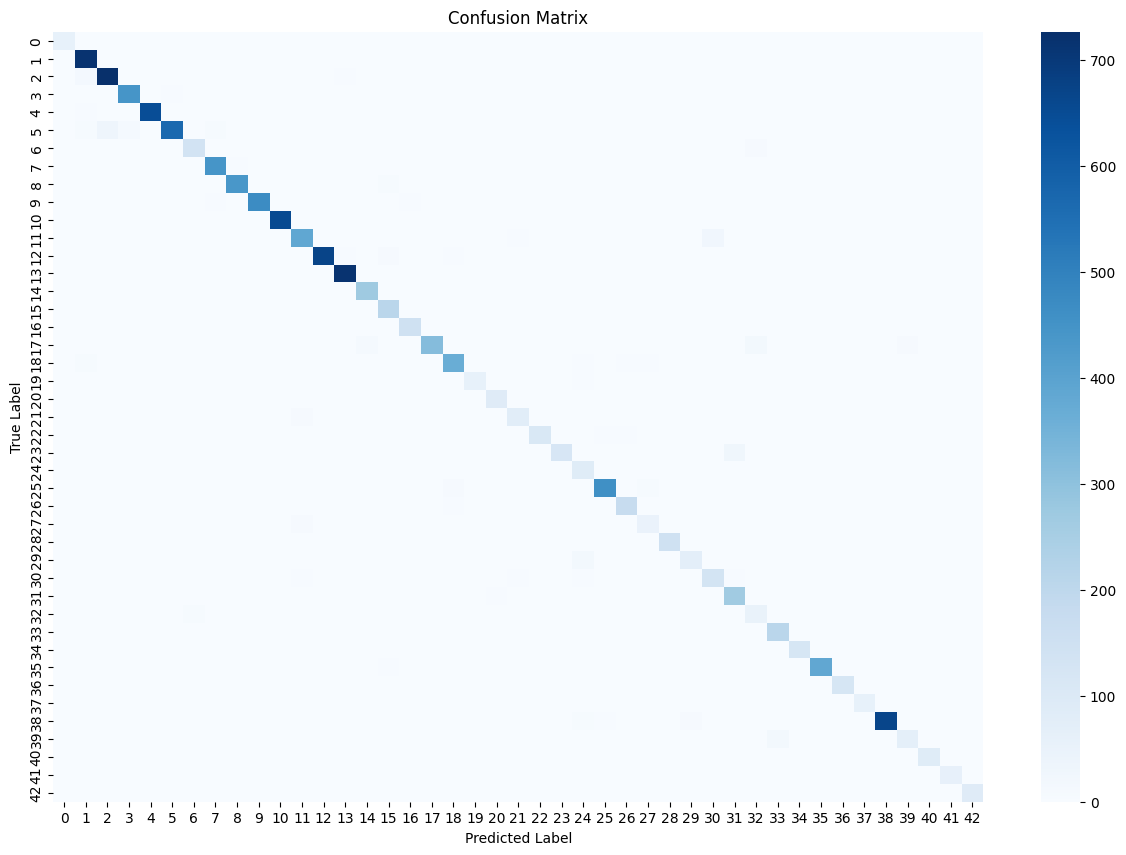

In [12]:
# Confusion Matrix Visualization
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, classes_x)
sns.heatmap(cm, annot=False, cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### FINAL PREDICTION

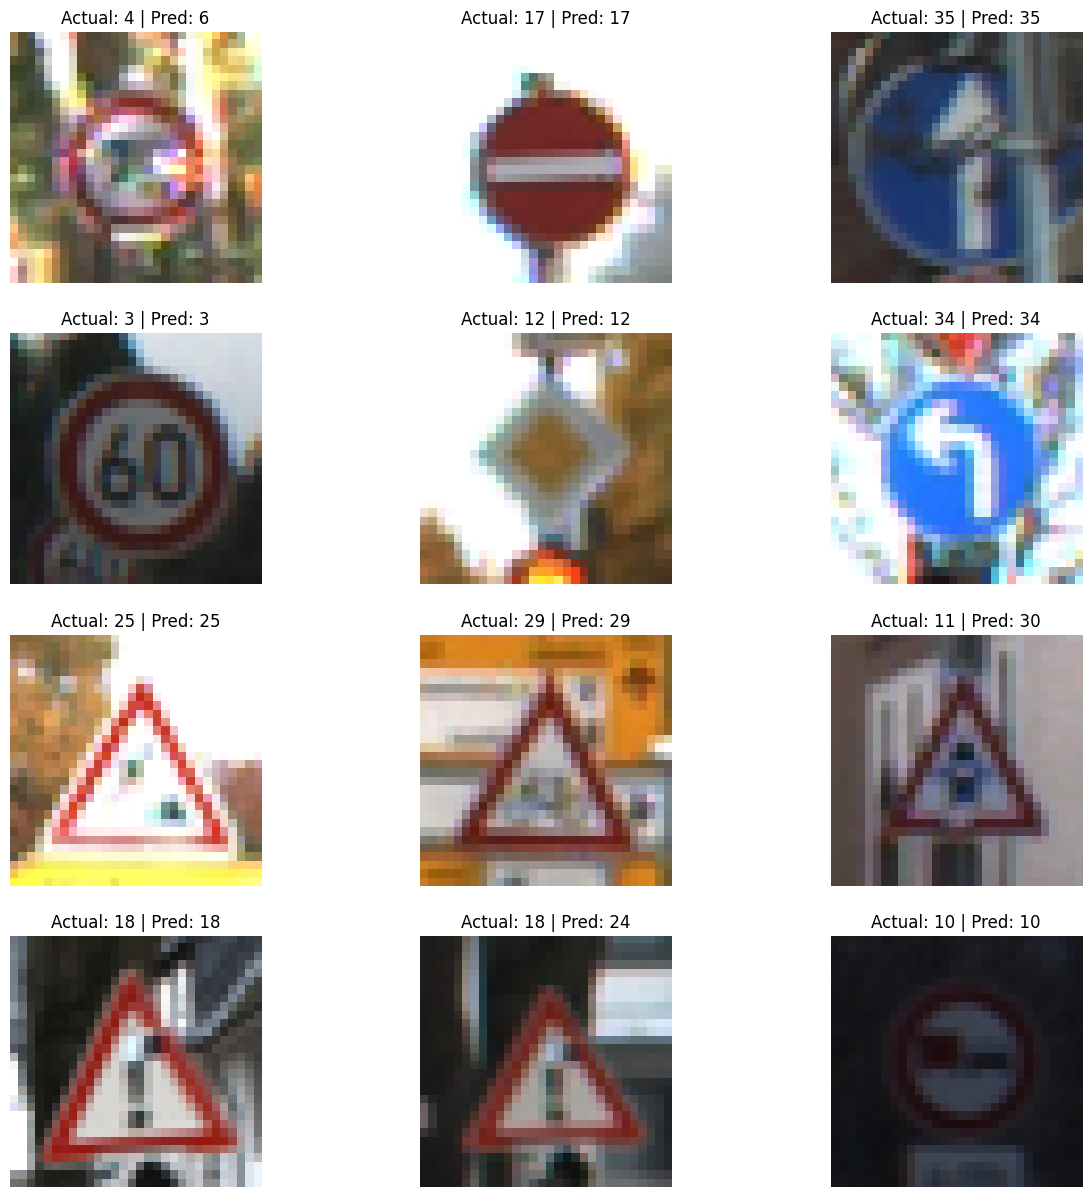

In [13]:
plt.figure(figsize=(15, 15))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    index = random.randint(0, len(X_test))
    plt.imshow(X_test[index])
    plt.title(f"Actual: {y_test[index]} | Pred: {classes_x[index]}")
    plt.axis('off')
plt.show()

##### SAVE THE MODEL

In [14]:
# Model saving
model.save('traffic_classifier.h5')
print("Model saved successfully as traffic_classifier.h5")

Model saved successfully as traffic_classifier.h5


## CONCLUSION

In this project, we successfully built a Deep Learning model using CNN to classify traffic signs with high precision. Starting from data exploration and handling class imbalances through Augmentation, we moved to designing a robust architecture.

Key Takeaways:

The model achieved a test accuracy of over 96.47% (check your final score).

Data augmentation played a vital role in helping the model generalize across different lighting and tilt conditions.

The confusion matrix shows that the model performs exceptionally well across most classes, though some similar-looking signs (like speed limits) can be tricky.